In [1]:
import pandas as pd

df = pd.read_csv("/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/train_data.csv")
df.head()

,Unnamed: 0,subject_ID,text,Anorexia
0,0,subject1074_1,[pc] [h] 4 keys maybe 5? [w] endo so why doe...,0
1,1,subject1101_1,Because he saw a movie once? It's Canadian ...,0
2,2,subject1120_1,What book should I read next that will scare ...,0
3,3,subject1137_1,''I only drink soda at parties'' Are you ex...,0
4,4,subject1143_1,"Once I named myself 'pros solo', the number ...",0


In [2]:
df.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
df.fillna("<PAD>", inplace=True)
df = df.astype({'text': str, 'Anorexia': int})
print(df.dtypes)
print(df.head())

subject_ID    object
text          object
Anorexia       int64
dtype: object
      subject_ID                                               text  Anorexia
0  subject1074_1   [pc] [h] 4 keys maybe 5? [w] endo  so why doe...         0
1  subject1101_1    Because he saw a movie once?  It's Canadian ...         0
2  subject1120_1   What book should I read next that will scare ...         0
3  subject1137_1    ''I only drink soda at parties''  Are you ex...         0
4  subject1143_1    Once I named myself 'pros solo', the number ...         0


In [3]:
import re

def remove_urls(text):
    # Define the pattern to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')

    # Replace URLs with an empty string
    text_without_urls = url_pattern.sub('', text)
    text_wihtout_urls = ''.join(filter(lambda x: x.isalpha() or x.isdigit() or x.isspace(), text_without_urls))
    return text_without_urls

In [1]:
import re

def clean_text(text):
    # Remove URLs
    text = re.sub(R"https?://\S+|www\.\S+", "", text)
    # Remove brackets (both round and square brackets)
    text = re.sub(r"[\(\)\[\]\{\}]", "", text)
    # Remove punctuation marks and non-word characters
    text = re.sub(r"[^\w\s]", "", text)
    return text

In [5]:
import warnings
warnings.filterwarnings("ignore")

for i in range(0, len(df)):
    df['text'][i] = clean_text(df['text'][i])
df.head()

,subject_ID,text,Anorexia
0,subject1074_1,pc h 4 keys maybe 5 w endo so why does my pc...,0
1,subject1101_1,Because he saw a movie once Its Canadian an...,0
2,subject1120_1,What book should I read next that will scare ...,0
3,subject1137_1,I only drink soda at parties Are you expens...,0
4,subject1143_1,Once I named myself pros solo the number of ...,0


In [6]:
df = df.astype({'subject_ID':str, 'text': str, 'Anorexia': int})
print(df.dtypes)

subject_ID    object
text          object
Anorexia       int64
dtype: object


In [1]:
import torch
import pandas as pd
import numpy as np
import re
import os
from glob import glob
from tqdm import tqdm
from transformers import LongformerTokenizer, LongformerModel
import torch
import torch.nn as nn
import torch.nn.functional as F
import datasets

In [ ]:
from transformers import LongformerTokenizer, LongformerModel

tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096", 
                                                cache_dir="/vast/palmer/scratch/liu_xiaofeng/ss4786/venv/model_weights")
model = LongformerModel.from_pretrained("allenai/longformer-base-4096",
                                        cache_dir="/vast/palmer/scratch/liu_xiaofeng/ss4786/venv/model_weights")
Device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(Device)

LongformerModel(
  (embeddings): LongformerEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (position_embeddings): Embedding(4098, 768, padding_idx=1)
  )
  (encoder): LongformerEncoder(
    (layer): ModuleList(
      (0-11): 12 x LongformerLayer(
        (attention): LongformerAttention(
          (self): LongformerSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (query_global): Linear(in_features=768, out_features=768, bias=True)
            (key_global): Linear(in_features=768, out_features=768, bias=True)
            (value_global): Linear(in_features=768, out_features=768, bias=True)
          )
    

In [9]:
tokenizer

LongformerTokenizer(name_or_path='allenai/longformer-base-4096', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [4]:
import torch
from torch import Tensor
from transformers import PreTrainedTokenizerBase

def split_overlapping(tensor: Tensor, chunk_size: int, stride: int, minimal_chunk_length: int):
    input_ids = tensor["input_ids"].squeeze(0)
    attn_mask = tensor["attention_mask"].squeeze(0)
    result_input_id = [input_ids[i: i+chunk_size] for i in range(0, len(input_ids), stride)]
    result_attn_mask = [attn_mask[i: i+chunk_size] for i in range(0, len(attn_mask), stride)]
    if len(result_input_id) > 1:
        result_input_id = [x for x in result_input_id if len(x) >= minimal_chunk_length]
        result_attn_mask = [x for x in result_attn_mask if len(x) >= minimal_chunk_length]
    return result_input_id, result_attn_mask

def add_special_tokens(input_id_chunks: list[Tensor], mask_chunks: list[Tensor]):
    for i in range(len(input_id_chunks)):
        input_id_chunks[i] = torch.cat([Tensor([0]), input_id_chunks[i], Tensor([2])])
        mask_chunks[i] = torch.cat([Tensor([1]), mask_chunks[i], Tensor([1])])

def add_padding(input_id_chunks: list[Tensor], mask_chunks: list[Tensor]):
    for i in range(len(input_id_chunks)):
        pad_len = 4096 - input_id_chunks[i].shape[0]
        if pad_len > 0:
            input_id_chunks[i] = torch.cat([input_id_chunks[i], Tensor([0]*pad_len)])
            mask_chunks[i] = torch.cat([mask_chunks[i], Tensor([0]*pad_len)])

def stack_tokens(input_id_chunks: list[Tensor], mask_chunks: list[Tensor]):
    input_ids = torch.stack(input_id_chunks)
    attn_mask = torch.stack(mask_chunks)
    return input_ids.long(), attn_mask.int()

def transform_single_text(text: str, tokenizer: PreTrainedTokenizerBase,
                          chunk_size: int, stride: int, minimal_chunk_length: int):
    tokens = tokenizer(text, add_special_tokens=False, truncation=False, return_tensors="pt")
    input_id_chunks, mask_chunks = split_overlapping(tokens, chunk_size, stride, minimal_chunk_length)
    add_special_tokens(input_id_chunks, mask_chunks)
    add_padding(input_id_chunks, mask_chunks)
    input_ids, attention_mask = stack_tokens(input_id_chunks, mask_chunks)
    return input_ids, attention_mask

In [11]:
for index, row in tqdm(df.iterrows()):
    text = row['text']
    target = row['Anorexia']
    index = row['subject_ID']
    temp = []
    model.eval()
    input_ids, attn_mask = transform_single_text(text, tokenizer, 4094, 4094, 1)
    for i in range(0, input_ids.shape[0]):
        inputs = {'input_ids': input_ids[i].unsqueeze(0).to(Device), 'attention_mask': attn_mask[i].unsqueeze(0).to(Device)}
        with torch.no_grad():
            output = model(**inputs)
        temp.append(output.last_hidden_state.squeeze().cpu())
    final_logits = torch.cat(temp, dim=0)
    np.save(f"/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/train_dataset/{index}.npy",
            final_logits.cpu().numpy())

2332it [15:55,  2.44it/s]


# Dataset

In [2]:
dataset_dict = torch.load("/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/lngfrm_patchtst_dataset.pth")

/tmp/tmp.cSN7iLPZSI/ipykernel_128936/3618125370.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset_dict = torch.load("/vast/palmer/scratch/liu_xiaofeng/ss4786/soura

In [3]:
for keys in dataset_dict.keys():
    dataset_dict[keys]['logits_path'] = '/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/train_dataset/' + dataset_dict[keys]['logits_path'].split('/')[-1]

In [4]:
for keys in dataset_dict.keys():
    print(dataset_dict[keys])
    break

{'time': [[18, 1], [18, 0], [17, 50], [17, 49], [17, 36], [17, 26]], 'logits_path': '/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/train_dataset/subject1113_1.npy', 'label': 1}


In [5]:
import random

def split_dictionary(data):
    # Separate entries with label 0 and label 1
    label_0_entries = {k: v for k, v in data.items() if v['label'] == 0}
    label_1_entries = {k: v for k, v in data.items() if v['label'] == 1}
    
    # Calculate the number of entries to be moved
    num_label_0_to_move = int(0.2 * len(label_0_entries))
    num_label_1_to_move = int(0.4 * len(label_1_entries))
    
    # Randomly select entries to be moved
    label_0_keys_to_move = random.sample(list(label_0_entries.keys()), num_label_0_to_move)
    label_1_keys_to_move = random.sample(list(label_1_entries.keys()), num_label_1_to_move)
    
    # Create the new dictionaries
    moved_entries = {k: label_0_entries[k] for k in label_0_keys_to_move}
    moved_entries.update({k: label_1_entries[k] for k in label_1_keys_to_move})
    
    remaining_entries = {k: v for k, v in data.items() if k not in moved_entries}
    
    return moved_entries, remaining_entries



val_dataset_dict, train_dataset_dict = split_dictionary(dataset_dict)
print("Moved Entries:")
print(len(val_dataset_dict))
print("Remaining Entries:")
print(len(train_dataset_dict))


Moved Entries:
520
Remaining Entries:
1811


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np


class TimeSeriesDataset(Dataset):
    def __init__(self, data, max_len):
        self.data = data
        self.max_len = max_len
        self.subjects = list(data.keys())

    def __len__(self):
        return len(self.subjects)

    def __getitem__(self, idx):
        subject = self.subjects[idx]
        time = self.data[subject]['time']
        logits_path = self.data[subject]['logits_path']
        label = self.data[subject]['label']

        # Padding
        padded_time = np.pad(time, ((0, self.max_len - len(time)), (0, 0)), 'constant')

        # print(padded_time.shape, padded_sentiment_score.shape)

        # Create past_observed_mask
        past_observed_mask = np.ones(self.max_len)
        past_observed_mask[len(time):] = 0  # Set mask to 0 for padded values


        return {
            'past_values': torch.tensor(padded_time, dtype=torch.float32),
            'true_label': torch.tensor([label], dtype=torch.float32),
            'past_observed_mask': torch.tensor(np.stack((past_observed_mask, past_observed_mask), axis=1), dtype=torch.bool),
            'text_logits_path': logits_path
        }


In [7]:
from sklearn.model_selection import train_test_split

# Set the maximum length of sequences to 2000
max_len = 2000

# Create dataset
train_dataset = TimeSeriesDataset(train_dataset_dict, max_len)
test_dataset = TimeSeriesDataset(val_dataset_dict, max_len)

# train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.attention = nn.MultiheadAttention(768, 12)
        self.fc1 = nn.Linear(in_features=768, out_features=384)
        self.fc2 = nn.Linear(in_features=384, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=32)
        self.fc4 = nn.Linear(in_features=32, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(0)
        x, _ = self.attention(x, x, x)
        x = x.squeeze(0)
        x = torch.relu(self.fc2(torch.relu(self.fc1(x))))
        # Perform global pooling over the batch dimension
        x = torch.relu(self.fc3(x))
        x = torch.mean(x, dim=0, keepdim=True)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

In [3]:
from transformers import PatchTSTConfig, PatchTSTForClassification

# classification task with two input channel2 and 3 classes
config = PatchTSTConfig(
    num_input_channels=2,
    num_targets=1,
    context_length=2000,
    patch_length=12,
    stride=12,
    use_cls_token=True,
    # loss='bce',
    head_dropout=0.5,
)

In [4]:
Device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Device = 'cpu'
model_patchtst = PatchTSTForClassification(config=config)
model_classifier = BinaryClassifier()
model_patchtst.to(Device)
model_classifier.to(Device)
optimizer1 = torch.optim.Adam(model_classifier.parameters(), lr=1e-4)
optimizer2 = torch.optim.Adam(model_patchtst.parameters(), lr=1e-4)
criterion = torch.nn.BCELoss()
# lambda1 = lambda epoch: 0.94 ** epoch
# scheduler1 = torch.optim.lr_scheduler.MultiStepLR(optimizer1, milestones=[5, 10, 15, 30], gamma=0.1)
# scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer2, milestones=[5, 10, 15, 30], gamma=0.1)
sigmoid = nn.Sigmoid()
alpha, beta = 1.0, 0.1
num_epochs = 10

In [11]:
optimizer1 = torch.optim.Adam(model_classifier.parameters(), lr=1e-3)
optimizer2 = torch.optim.Adam(model_patchtst.parameters(), lr=1e-3)
num_epochs = 10

In [12]:
def train_model(alpha, beta, path):
    model_patchtst = PatchTSTForClassification(config=config)
    model_classifier = BinaryClassifier()
    model_patchtst.to(Device)
    model_classifier.to(Device)
    optimizer1 = torch.optim.Adam(model_classifier.parameters(), lr=1e-4)
    optimizer2 = torch.optim.Adam(model_patchtst.parameters(), lr=1e-4)
    # scheduler1 = torch.optim.lr_scheduler.MultiStepLR(optimizer1, milestones=[5, 10, 15, 30], gamma=0.1)
    # scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer2, milestones=[5, 10, 15, 30], gamma=0.1)
    num_epochs = 10
    best_val_loss = 1
    model_patchtst.train()
    model_classifier.train()
    for epoch in range(num_epochs):
        loss_train = 0
        for data in tqdm(train_loader, desc=f"training epoch = {epoch}"):
            optimizer1.zero_grad()
            optimizer2.zero_grad()
            labels = data['true_label'].to(Device)
            output1 = model_patchtst(past_values=data['past_values'].to(Device), past_observed_mask=data['past_observed_mask'].to(Device))
            # print(output1.prediction_logits)
            output1 = sigmoid(output1.prediction_logits)
            output2 = torch.from_numpy(np.load(data['text_logits_path'][0])).to(Device)
            # print(output2.shape)
            output2 = model_classifier(output2)
            # print(output1, output2, labels)
            output2 = alpha*output2 + beta*output1
            output2 = torch.clamp(output2, max=1)
            loss = criterion(output2, labels)
            loss.backward()
            loss_train += loss.item()
            optimizer1.step()
            optimizer2.step()
        # scheduler2.step()
        # scheduler1.step()
        print(f"training_loss = {loss_train/len(train_loader)}")

        model_classifier.eval()
        model_patchtst.eval()
        val_loss = 0
        with torch.no_grad():
            for data in tqdm(test_loader, desc=f"validation epoch = {epoch}"):
                labels = data['true_label'].to(Device)
                output1 = model_patchtst(past_values=data['past_values'].to(Device), past_observed_mask=data['past_observed_mask'].to(Device))
                output1 = sigmoid(output1.prediction_logits)
                output2 = torch.from_numpy(np.load(data['text_logits_path'][0])).to(Device)
                # print(output2.shape)
                output2 = model_classifier(output2)
                output2 = alpha*output2 + beta*output1
                output2 = torch.clamp(output2, max=1)
                loss = criterion(output2, labels)
                val_loss += loss.item()
        val_loss /= len(test_loader)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model_patchtst.state_dict(),
                os.path.join("/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/alpha_beta_variation_ckpts",
                                f"model_best_patchtst_{path}.pt"))
            torch.save(model_classifier.state_dict(),
                os.path.join("/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/alpha_beta_variation_ckpts",
                                f"model_best_classifier_{path}.pt"))

        # if (epoch+1)%5 == 0:
        #     torch.save(model_classifier.state_dict(),
        #         os.path.join("/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/alpha_beta_variation_ckpts",
        #                         f"classifier_{path}_epoch_{epoch+1}_val_loss_{val_loss}.pt"))
        #     torch.save(model_patchtst.state_dict(),
        #         os.path.join("/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/alpha_beta_variation_ckpts",
        #                         f"patchtst_{path}_epoch_{epoch+1}_val_loss_{val_loss}.pt"))

        # print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Val loss: {val_loss:.4f}')
    return best_val_loss


In [13]:
list_alpha = []
list_beta = []
list_best_val_loss = []

for i in range(0, 10, 1):
    list_alpha.append(i)
    list_beta.append(1-i/10)
    print(f"alpha = {i/10}, beta = {(10-i)/10}")
    list_best_val_loss.append(train_model(i/10, (10-i)/10, f"{i}_{10-i}"))


alpha = 0.0, beta = 1.0


training epoch = 0:   0%|          | 0/1811 [00:00<?, ?it/s]

training epoch = 0: 100%|██████████| 1811/1811 [02:24<00:00, 12.49it/s]


training_loss = 0.3207083727135988


validation epoch = 0: 100%|██████████| 520/520 [00:24<00:00, 21.47it/s]


Val loss: 0.6780


training epoch = 1: 100%|██████████| 1811/1811 [02:14<00:00, 13.42it/s]


training_loss = 0.7252468763768949


validation epoch = 1: 100%|██████████| 520/520 [00:23<00:00, 22.04it/s]


Val loss: 1.1305


training epoch = 2: 100%|██████████| 1811/1811 [02:08<00:00, 14.14it/s]


training_loss = 0.6465256924194421


validation epoch = 2: 100%|██████████| 520/520 [00:21<00:00, 24.35it/s]


Val loss: 1.1122


training epoch = 3: 100%|██████████| 1811/1811 [02:08<00:00, 14.06it/s]


training_loss = 0.5189345941118847


validation epoch = 3: 100%|██████████| 520/520 [00:19<00:00, 26.24it/s]


Val loss: 1.1744


training epoch = 4: 100%|██████████| 1811/1811 [02:04<00:00, 14.58it/s]


training_loss = 0.3507139479733961


validation epoch = 4: 100%|██████████| 520/520 [00:22<00:00, 22.81it/s]


Val loss: 0.5465


training epoch = 5: 100%|██████████| 1811/1811 [02:06<00:00, 14.32it/s]


training_loss = 0.6042121195506182


validation epoch = 5: 100%|██████████| 520/520 [00:21<00:00, 24.49it/s]


Val loss: 0.5798


training epoch = 6: 100%|██████████| 1811/1811 [02:02<00:00, 14.84it/s]


training_loss = 0.38917048538822635


validation epoch = 6: 100%|██████████| 520/520 [00:23<00:00, 22.47it/s]


Val loss: 0.6124


training epoch = 7: 100%|██████████| 1811/1811 [02:06<00:00, 14.28it/s]


training_loss = 0.3260308400604298


validation epoch = 7: 100%|██████████| 520/520 [00:21<00:00, 24.40it/s]


Val loss: 0.5699


training epoch = 8: 100%|██████████| 1811/1811 [02:01<00:00, 14.87it/s]


training_loss = 0.31472672336046675


validation epoch = 8: 100%|██████████| 520/520 [00:23<00:00, 22.40it/s]


Val loss: 0.6071


training epoch = 9: 100%|██████████| 1811/1811 [02:04<00:00, 14.53it/s]


training_loss = 0.3216508899930711


validation epoch = 9: 100%|██████████| 520/520 [00:21<00:00, 24.00it/s]


Val loss: 0.5603
alpha = 0.1, beta = 0.9


training epoch = 0: 100%|██████████| 1811/1811 [02:04<00:00, 14.52it/s]


training_loss = 0.3090066917367993


validation epoch = 0: 100%|██████████| 520/520 [00:23<00:00, 22.33it/s]


Val loss: 0.5306


training epoch = 1: 100%|██████████| 1811/1811 [02:03<00:00, 14.71it/s]


training_loss = 0.3138201628507731


validation epoch = 1: 100%|██████████| 520/520 [00:21<00:00, 24.02it/s]


Val loss: 0.5374


training epoch = 2: 100%|██████████| 1811/1811 [02:05<00:00, 14.38it/s]


training_loss = 0.29471065848242967


validation epoch = 2: 100%|██████████| 520/520 [00:22<00:00, 22.70it/s]


Val loss: 0.5337


training epoch = 3: 100%|██████████| 1811/1811 [02:05<00:00, 14.41it/s]


training_loss = 0.29161044208858466


validation epoch = 3: 100%|██████████| 520/520 [00:21<00:00, 24.23it/s]


Val loss: 0.5802


training epoch = 4: 100%|██████████| 1811/1811 [02:05<00:00, 14.49it/s]


training_loss = 0.28429423759509886


validation epoch = 4: 100%|██████████| 520/520 [00:22<00:00, 22.85it/s]


Val loss: 0.5396


training epoch = 5: 100%|██████████| 1811/1811 [02:06<00:00, 14.28it/s]


training_loss = 0.2504790265041786


validation epoch = 5: 100%|██████████| 520/520 [00:20<00:00, 24.99it/s]


Val loss: 0.5202


training epoch = 6: 100%|██████████| 1811/1811 [02:04<00:00, 14.52it/s]


training_loss = 0.24847067014352178


validation epoch = 6: 100%|██████████| 520/520 [00:23<00:00, 22.55it/s]


Val loss: 0.5000


training epoch = 7: 100%|██████████| 1811/1811 [02:05<00:00, 14.39it/s]


training_loss = 0.2551674915382238


validation epoch = 7: 100%|██████████| 520/520 [00:21<00:00, 23.69it/s]


Val loss: 0.5804


training epoch = 8: 100%|██████████| 1811/1811 [02:06<00:00, 14.35it/s]


training_loss = 0.250952582016807


validation epoch = 8: 100%|██████████| 520/520 [00:22<00:00, 22.71it/s]


Val loss: 0.5288


training epoch = 9: 100%|██████████| 1811/1811 [02:04<00:00, 14.57it/s]


training_loss = 0.24719628028541457


validation epoch = 9: 100%|██████████| 520/520 [00:23<00:00, 22.45it/s]


Val loss: 0.5067
alpha = 0.2, beta = 0.8


training epoch = 0: 100%|██████████| 1811/1811 [02:04<00:00, 14.58it/s]


training_loss = 0.2954346479338714


validation epoch = 0: 100%|██████████| 520/520 [00:21<00:00, 23.82it/s]


Val loss: 0.5569


training epoch = 1: 100%|██████████| 1811/1811 [02:04<00:00, 14.53it/s]


training_loss = 0.256574458828451


validation epoch = 1: 100%|██████████| 520/520 [00:23<00:00, 22.21it/s]


Val loss: 0.5754


training epoch = 2: 100%|██████████| 1811/1811 [02:06<00:00, 14.37it/s]


training_loss = 0.23220943870886654


validation epoch = 2: 100%|██████████| 520/520 [00:21<00:00, 23.79it/s]


Val loss: 0.6671


training epoch = 3: 100%|██████████| 1811/1811 [02:04<00:00, 14.57it/s]


training_loss = 0.241459889708896


validation epoch = 3: 100%|██████████| 520/520 [00:23<00:00, 22.37it/s]


Val loss: 0.4396


training epoch = 4: 100%|██████████| 1811/1811 [02:05<00:00, 14.42it/s]


training_loss = 0.214629436471481


validation epoch = 4: 100%|██████████| 520/520 [00:21<00:00, 24.27it/s]


Val loss: 0.4999


training epoch = 5: 100%|██████████| 1811/1811 [02:06<00:00, 14.36it/s]


training_loss = 0.2187130926351238


validation epoch = 5: 100%|██████████| 520/520 [00:22<00:00, 22.63it/s]


Val loss: 0.4603


training epoch = 6: 100%|██████████| 1811/1811 [02:05<00:00, 14.40it/s]


training_loss = 0.22980370045555237


validation epoch = 6: 100%|██████████| 520/520 [00:22<00:00, 23.62it/s]


Val loss: 0.4572


training epoch = 7: 100%|██████████| 1811/1811 [02:04<00:00, 14.57it/s]


training_loss = 0.2136187955918386


validation epoch = 7: 100%|██████████| 520/520 [00:23<00:00, 22.26it/s]


Val loss: 0.5234


training epoch = 8: 100%|██████████| 1811/1811 [02:07<00:00, 14.25it/s]


training_loss = 0.21493591277522558


validation epoch = 8: 100%|██████████| 520/520 [00:21<00:00, 24.58it/s]


Val loss: 0.4499


training epoch = 9: 100%|██████████| 1811/1811 [02:03<00:00, 14.67it/s]


training_loss = 0.2049356578779402


validation epoch = 9: 100%|██████████| 520/520 [00:23<00:00, 22.31it/s]


Val loss: 0.4578
alpha = 0.3, beta = 0.7


training epoch = 0: 100%|██████████| 1811/1811 [02:08<00:00, 14.06it/s]


training_loss = 0.2903042306860413


validation epoch = 0: 100%|██████████| 520/520 [00:20<00:00, 25.72it/s]


Val loss: 0.4542


training epoch = 1: 100%|██████████| 1811/1811 [02:03<00:00, 14.71it/s]


training_loss = 0.22779107822219968


validation epoch = 1: 100%|██████████| 520/520 [00:23<00:00, 22.38it/s]


Val loss: 0.4315


training epoch = 2: 100%|██████████| 1811/1811 [02:07<00:00, 14.24it/s]


training_loss = 0.20321120156377886


validation epoch = 2: 100%|██████████| 520/520 [00:20<00:00, 25.28it/s]


Val loss: 0.3877


training epoch = 3: 100%|██████████| 1811/1811 [02:03<00:00, 14.71it/s]


training_loss = 0.21110687120609647


validation epoch = 3: 100%|██████████| 520/520 [00:23<00:00, 22.47it/s]


Val loss: 0.5140


training epoch = 4: 100%|██████████| 1811/1811 [02:06<00:00, 14.27it/s]


training_loss = 0.19861762774843375


validation epoch = 4: 100%|██████████| 520/520 [00:22<00:00, 23.52it/s]


Val loss: 0.3983


training epoch = 5: 100%|██████████| 1811/1811 [02:06<00:00, 14.37it/s]


training_loss = 0.23884869871757747


validation epoch = 5: 100%|██████████| 520/520 [00:22<00:00, 22.79it/s]


Val loss: 0.3955


training epoch = 6: 100%|██████████| 1811/1811 [02:04<00:00, 14.51it/s]


training_loss = 0.1880148227880782


validation epoch = 6: 100%|██████████| 520/520 [00:22<00:00, 23.45it/s]


Val loss: 0.5344


training epoch = 7: 100%|██████████| 1811/1811 [02:06<00:00, 14.33it/s]


training_loss = 0.20083664876861426


validation epoch = 7: 100%|██████████| 520/520 [00:22<00:00, 22.94it/s]


Val loss: 0.4074


training epoch = 8: 100%|██████████| 1811/1811 [02:04<00:00, 14.53it/s]


training_loss = 0.18665784514053388


validation epoch = 8: 100%|██████████| 520/520 [00:22<00:00, 22.72it/s]


Val loss: 0.4032


training epoch = 9: 100%|██████████| 1811/1811 [02:05<00:00, 14.48it/s]


training_loss = 0.19090310278795258


validation epoch = 9: 100%|██████████| 520/520 [00:22<00:00, 23.25it/s]


Val loss: 0.4024
alpha = 0.4, beta = 0.6


training epoch = 0: 100%|██████████| 1811/1811 [02:06<00:00, 14.33it/s]


training_loss = 0.27200678916759913


validation epoch = 0: 100%|██████████| 520/520 [00:22<00:00, 22.97it/s]


Val loss: 0.3938


training epoch = 1: 100%|██████████| 1811/1811 [02:03<00:00, 14.62it/s]


training_loss = 0.2036659436093954


validation epoch = 1: 100%|██████████| 520/520 [00:22<00:00, 22.80it/s]


Val loss: 0.4168


training epoch = 2: 100%|██████████| 1811/1811 [02:06<00:00, 14.26it/s]


training_loss = 0.1950761256837126


validation epoch = 2: 100%|██████████| 520/520 [00:22<00:00, 23.35it/s]


Val loss: 0.5304


training epoch = 3: 100%|██████████| 1811/1811 [02:04<00:00, 14.58it/s]


training_loss = 0.18398650725434362


validation epoch = 3: 100%|██████████| 520/520 [00:23<00:00, 22.53it/s]


Val loss: 0.6711


training epoch = 4: 100%|██████████| 1811/1811 [02:03<00:00, 14.63it/s]


training_loss = 0.19505228583572648


validation epoch = 4: 100%|██████████| 520/520 [00:22<00:00, 22.73it/s]


Val loss: 0.4653


training epoch = 5: 100%|██████████| 1811/1811 [02:04<00:00, 14.51it/s]


training_loss = 0.17588743017476657


validation epoch = 5: 100%|██████████| 520/520 [00:22<00:00, 23.16it/s]


Val loss: 0.3959


training epoch = 6: 100%|██████████| 1811/1811 [02:04<00:00, 14.54it/s]


training_loss = 0.1788793825296287


validation epoch = 6: 100%|██████████| 520/520 [00:23<00:00, 22.25it/s]


Val loss: 0.3711


training epoch = 7: 100%|██████████| 1811/1811 [02:05<00:00, 14.46it/s]


training_loss = 0.1689342341261974


validation epoch = 7: 100%|██████████| 520/520 [00:22<00:00, 23.20it/s]


Val loss: 0.4178


training epoch = 8: 100%|██████████| 1811/1811 [02:03<00:00, 14.63it/s]


training_loss = 0.16303645517057516


validation epoch = 8: 100%|██████████| 520/520 [00:22<00:00, 22.63it/s]


Val loss: 0.4071


training epoch = 9: 100%|██████████| 1811/1811 [02:04<00:00, 14.55it/s]


training_loss = 0.16769577271198574


validation epoch = 9: 100%|██████████| 520/520 [00:22<00:00, 23.38it/s]


Val loss: 0.3195
alpha = 0.5, beta = 0.5


training epoch = 0: 100%|██████████| 1811/1811 [02:03<00:00, 14.63it/s]


training_loss = 0.27159674019753377


validation epoch = 0: 100%|██████████| 520/520 [00:22<00:00, 23.16it/s]


Val loss: 0.3934


training epoch = 1: 100%|██████████| 1811/1811 [02:04<00:00, 14.53it/s]


training_loss = 0.20359194028311606


validation epoch = 1: 100%|██████████| 520/520 [00:21<00:00, 24.66it/s]


Val loss: 0.3523


training epoch = 2: 100%|██████████| 1811/1811 [02:04<00:00, 14.57it/s]


training_loss = 0.18717692501628017


validation epoch = 2: 100%|██████████| 520/520 [00:22<00:00, 22.76it/s]


Val loss: 0.5061


training epoch = 3: 100%|██████████| 1811/1811 [02:07<00:00, 14.25it/s]


training_loss = 0.182689375819183


validation epoch = 3: 100%|██████████| 520/520 [00:21<00:00, 23.88it/s]


Val loss: 0.3596


training epoch = 4: 100%|██████████| 1811/1811 [02:04<00:00, 14.56it/s]


training_loss = 0.17804895498315956


validation epoch = 4: 100%|██████████| 520/520 [00:22<00:00, 22.90it/s]


Val loss: 0.3680


training epoch = 5: 100%|██████████| 1811/1811 [02:08<00:00, 14.12it/s]


training_loss = 0.1786731739300321


validation epoch = 5: 100%|██████████| 520/520 [00:22<00:00, 23.46it/s]


Val loss: 0.4172


training epoch = 6: 100%|██████████| 1811/1811 [02:03<00:00, 14.65it/s]


training_loss = 0.169267354868373


validation epoch = 6: 100%|██████████| 520/520 [00:22<00:00, 23.06it/s]


Val loss: 0.3546


training epoch = 7: 100%|██████████| 1811/1811 [02:05<00:00, 14.48it/s]


training_loss = 0.17678948086234367


validation epoch = 7: 100%|██████████| 520/520 [00:22<00:00, 23.13it/s]


Val loss: 0.3197


training epoch = 8: 100%|██████████| 1811/1811 [02:05<00:00, 14.48it/s]


training_loss = 0.1636313919709123


validation epoch = 8: 100%|██████████| 520/520 [00:22<00:00, 23.39it/s]


Val loss: 0.3557


training epoch = 9: 100%|██████████| 1811/1811 [02:04<00:00, 14.49it/s]


training_loss = 0.16214915507650535


validation epoch = 9: 100%|██████████| 520/520 [00:23<00:00, 22.56it/s]


Val loss: 0.3422
alpha = 0.6, beta = 0.4


training epoch = 0: 100%|██████████| 1811/1811 [02:06<00:00, 14.35it/s]


training_loss = 0.27724162427099897


validation epoch = 0: 100%|██████████| 520/520 [00:22<00:00, 23.57it/s]


Val loss: 0.3992


training epoch = 1: 100%|██████████| 1811/1811 [02:04<00:00, 14.58it/s]


training_loss = 0.19553303531085384


validation epoch = 1: 100%|██████████| 520/520 [00:22<00:00, 23.05it/s]


Val loss: 0.4036


training epoch = 2: 100%|██████████| 1811/1811 [02:05<00:00, 14.38it/s]


training_loss = 0.1757903042169583


validation epoch = 2: 100%|██████████| 520/520 [00:21<00:00, 23.67it/s]


Val loss: 0.4746


training epoch = 3: 100%|██████████| 1811/1811 [02:05<00:00, 14.46it/s]


training_loss = 0.17141013312988015


validation epoch = 3: 100%|██████████| 520/520 [00:23<00:00, 22.44it/s]


Val loss: 0.3314


training epoch = 4: 100%|██████████| 1811/1811 [02:03<00:00, 14.67it/s]


training_loss = 0.16585810381267288


validation epoch = 4: 100%|██████████| 520/520 [00:22<00:00, 22.93it/s]


Val loss: 0.3599


training epoch = 5: 100%|██████████| 1811/1811 [02:06<00:00, 14.34it/s]


training_loss = 0.16089929187336938


validation epoch = 5: 100%|██████████| 520/520 [00:21<00:00, 23.73it/s]


Val loss: 0.4719


training epoch = 6: 100%|██████████| 1811/1811 [02:04<00:00, 14.54it/s]


training_loss = 0.15546801405303223


validation epoch = 6: 100%|██████████| 520/520 [00:22<00:00, 22.68it/s]


Val loss: 0.3169


training epoch = 7: 100%|██████████| 1811/1811 [02:05<00:00, 14.38it/s]


training_loss = 0.15101844966949973


validation epoch = 7: 100%|██████████| 520/520 [00:21<00:00, 24.16it/s]


Val loss: 0.3133


training epoch = 8: 100%|██████████| 1811/1811 [02:04<00:00, 14.52it/s]


training_loss = 0.14588538355669983


validation epoch = 8: 100%|██████████| 520/520 [00:23<00:00, 22.15it/s]


Val loss: 0.4201


training epoch = 9: 100%|██████████| 1811/1811 [02:05<00:00, 14.40it/s]


training_loss = 0.13754540955671665


validation epoch = 9: 100%|██████████| 520/520 [00:21<00:00, 24.64it/s]


Val loss: 0.6058
alpha = 0.7, beta = 0.3


training epoch = 0: 100%|██████████| 1811/1811 [02:06<00:00, 14.29it/s]


training_loss = 0.2718502313055742


validation epoch = 0: 100%|██████████| 520/520 [00:23<00:00, 22.21it/s]


Val loss: 0.4217


training epoch = 1: 100%|██████████| 1811/1811 [02:05<00:00, 14.37it/s]


training_loss = 0.18688264953035272


validation epoch = 1: 100%|██████████| 520/520 [00:21<00:00, 23.75it/s]


Val loss: 0.4361


training epoch = 2: 100%|██████████| 1811/1811 [02:04<00:00, 14.55it/s]


training_loss = 0.1727906185256812


validation epoch = 2: 100%|██████████| 520/520 [00:22<00:00, 22.73it/s]


Val loss: 0.3177


training epoch = 3: 100%|██████████| 1811/1811 [02:07<00:00, 14.22it/s]


training_loss = 0.1723140834425144


validation epoch = 3: 100%|██████████| 520/520 [00:21<00:00, 23.75it/s]


Val loss: 0.3516


training epoch = 4: 100%|██████████| 1811/1811 [02:04<00:00, 14.53it/s]


training_loss = 0.16986144195965616


validation epoch = 4: 100%|██████████| 520/520 [00:23<00:00, 21.79it/s]


Val loss: 0.3761


training epoch = 5: 100%|██████████| 1811/1811 [02:07<00:00, 14.24it/s]


training_loss = 0.16098030839285055


validation epoch = 5: 100%|██████████| 520/520 [00:21<00:00, 24.28it/s]


Val loss: 0.3021


training epoch = 6: 100%|██████████| 1811/1811 [02:05<00:00, 14.45it/s]


training_loss = 0.15700484283156535


validation epoch = 6: 100%|██████████| 520/520 [00:23<00:00, 22.60it/s]


Val loss: 0.3432


training epoch = 7: 100%|██████████| 1811/1811 [02:04<00:00, 14.52it/s]


training_loss = 0.1504255932218159


validation epoch = 7: 100%|██████████| 520/520 [00:22<00:00, 23.14it/s]


Val loss: 0.2767


training epoch = 8: 100%|██████████| 1811/1811 [02:04<00:00, 14.54it/s]


training_loss = 0.14701421428565897


validation epoch = 8: 100%|██████████| 520/520 [00:22<00:00, 23.10it/s]


Val loss: 0.3272


training epoch = 9: 100%|██████████| 1811/1811 [02:06<00:00, 14.37it/s]


training_loss = 0.14101685405655928


validation epoch = 9: 100%|██████████| 520/520 [00:22<00:00, 23.14it/s]


Val loss: 0.3347
alpha = 0.8, beta = 0.2


training epoch = 0: 100%|██████████| 1811/1811 [02:06<00:00, 14.28it/s]


training_loss = 0.2702939334884114


validation epoch = 0: 100%|██████████| 520/520 [00:22<00:00, 23.26it/s]


Val loss: 0.4110


training epoch = 1: 100%|██████████| 1811/1811 [02:04<00:00, 14.51it/s]


training_loss = 0.1852110989086117


validation epoch = 1: 100%|██████████| 520/520 [00:22<00:00, 22.81it/s]


Val loss: 0.3225


training epoch = 2: 100%|██████████| 1811/1811 [02:06<00:00, 14.27it/s]


training_loss = 0.17220137274324263


validation epoch = 2: 100%|██████████| 520/520 [00:22<00:00, 23.38it/s]


Val loss: 0.3505


training epoch = 3: 100%|██████████| 1811/1811 [02:07<00:00, 14.22it/s]


training_loss = 0.17367240100388245


validation epoch = 3: 100%|██████████| 520/520 [00:22<00:00, 22.82it/s]


Val loss: 0.3559


training epoch = 4: 100%|██████████| 1811/1811 [02:03<00:00, 14.64it/s]


training_loss = 0.16425902387028365


validation epoch = 4: 100%|██████████| 520/520 [00:22<00:00, 23.14it/s]


Val loss: 0.2990


training epoch = 5: 100%|██████████| 1811/1811 [02:05<00:00, 14.39it/s]


training_loss = 0.15543465011901256


validation epoch = 5: 100%|██████████| 520/520 [00:21<00:00, 24.29it/s]


Val loss: 0.3999


training epoch = 6: 100%|██████████| 1811/1811 [02:04<00:00, 14.49it/s]


training_loss = 0.15174008672972664


validation epoch = 6: 100%|██████████| 520/520 [00:22<00:00, 22.80it/s]


Val loss: 0.3265


training epoch = 7: 100%|██████████| 1811/1811 [02:07<00:00, 14.22it/s]


training_loss = 0.14873033465577418


validation epoch = 7: 100%|██████████| 520/520 [00:22<00:00, 23.49it/s]


Val loss: 0.3030


training epoch = 8: 100%|██████████| 1811/1811 [02:04<00:00, 14.50it/s]


training_loss = 0.14263292751501544


validation epoch = 8: 100%|██████████| 520/520 [00:23<00:00, 22.43it/s]


Val loss: 0.2909


training epoch = 9: 100%|██████████| 1811/1811 [02:05<00:00, 14.39it/s]


training_loss = 0.13860259064355032


validation epoch = 9: 100%|██████████| 520/520 [00:22<00:00, 23.07it/s]


Val loss: 0.3254
alpha = 0.9, beta = 0.1


training epoch = 0: 100%|██████████| 1811/1811 [02:03<00:00, 14.64it/s]


training_loss = 0.2699734170100486


validation epoch = 0: 100%|██████████| 520/520 [00:23<00:00, 22.27it/s]


Val loss: 0.3712


training epoch = 1: 100%|██████████| 1811/1811 [02:07<00:00, 14.24it/s]


training_loss = 0.1894654649551869


validation epoch = 1: 100%|██████████| 520/520 [00:21<00:00, 24.54it/s]


Val loss: 0.3870


training epoch = 2: 100%|██████████| 1811/1811 [02:03<00:00, 14.71it/s]


training_loss = 0.17443327040470413


validation epoch = 2: 100%|██████████| 520/520 [00:23<00:00, 22.32it/s]


Val loss: 0.3812


training epoch = 3: 100%|██████████| 1811/1811 [02:06<00:00, 14.36it/s]


training_loss = 0.16907011588491822


validation epoch = 3: 100%|██████████| 520/520 [00:21<00:00, 24.65it/s]


Val loss: 0.3061


training epoch = 4: 100%|██████████| 1811/1811 [02:04<00:00, 14.58it/s]


training_loss = 0.16547223945762315


validation epoch = 4: 100%|██████████| 520/520 [00:23<00:00, 22.43it/s]


Val loss: 0.3188


training epoch = 5: 100%|██████████| 1811/1811 [02:06<00:00, 14.34it/s]


training_loss = 0.15974339609991395


validation epoch = 5: 100%|██████████| 520/520 [00:21<00:00, 23.87it/s]


Val loss: 0.4441


training epoch = 6: 100%|██████████| 1811/1811 [02:04<00:00, 14.54it/s]


training_loss = 0.15993674057118634


validation epoch = 6: 100%|██████████| 520/520 [00:23<00:00, 22.33it/s]


Val loss: 0.3789


training epoch = 7: 100%|██████████| 1811/1811 [02:05<00:00, 14.40it/s]


training_loss = 0.15066869677300648


validation epoch = 7: 100%|██████████| 520/520 [00:22<00:00, 23.16it/s]


Val loss: 0.2790


training epoch = 8: 100%|██████████| 1811/1811 [02:04<00:00, 14.50it/s]


training_loss = 0.14997537818602721


validation epoch = 8: 100%|██████████| 520/520 [00:22<00:00, 22.93it/s]


Val loss: 0.3611


training epoch = 9: 100%|██████████| 1811/1811 [02:05<00:00, 14.41it/s]


training_loss = 0.14716151816319797


validation epoch = 9: 100%|██████████| 520/520 [00:22<00:00, 23.18it/s]


Val loss: 0.2745


In [14]:
print(list_alpha)
print(list_beta)
print(list_best_val_loss)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.30000000000000004, 0.19999999999999996, 0.09999999999999998]
[0.546545902836638, 0.5000103966225512, 0.4395691953169612, 0.38772905289840237, 0.3195176275650747, 0.31974988341188204, 0.31329465303450027, 0.27665116709635745, 0.2909494792068629, 0.2745214396254596]


In [13]:
list_alpha = []
list_beta = []
list_best_val_loss = []

for i in range(8, 10, 1):
    for j in range(8, 10, 1):
        if(i+j>10 and i>=j):
            list_alpha.append(i)
            list_beta.append(j)
            print(f"alpha = {i/10}, beta = {j/10}")
            list_best_val_loss.append(train_model(i/10, j/10, f"{i}_{j}"))

alpha = 0.8, beta = 0.8


training epoch = 0:   0%|          | 0/1811 [00:00<?, ?it/s]

training epoch = 0: 100%|██████████| 1811/1811 [03:48<00:00,  7.92it/s]


training_loss = 0.2960131649816598


validation epoch = 0: 100%|██████████| 520/520 [01:01<00:00,  8.44it/s]


Val loss: 0.3406


training epoch = 1: 100%|██████████| 1811/1811 [03:46<00:00,  8.00it/s]


training_loss = 0.19494777327833251


validation epoch = 1: 100%|██████████| 520/520 [01:02<00:00,  8.29it/s]


Val loss: 0.3699


training epoch = 2: 100%|██████████| 1811/1811 [03:49<00:00,  7.89it/s]


training_loss = 0.17739276683298338


validation epoch = 2: 100%|██████████| 520/520 [01:02<00:00,  8.37it/s]


Val loss: 0.3196


training epoch = 3: 100%|██████████| 1811/1811 [03:51<00:00,  7.82it/s]


training_loss = 0.170267690413797


validation epoch = 3: 100%|██████████| 520/520 [00:59<00:00,  8.76it/s]


Val loss: 0.2826


training epoch = 4: 100%|██████████| 1811/1811 [03:51<00:00,  7.83it/s]


training_loss = 0.16507059332513546


validation epoch = 4: 100%|██████████| 520/520 [01:00<00:00,  8.55it/s]


Val loss: 0.3511


training epoch = 5: 100%|██████████| 1811/1811 [03:51<00:00,  7.81it/s]


training_loss = 0.15368440764452657


validation epoch = 5: 100%|██████████| 520/520 [01:01<00:00,  8.49it/s]


Val loss: 0.2949


training epoch = 6: 100%|██████████| 1811/1811 [03:53<00:00,  7.75it/s]


training_loss = 0.14991037514123745


validation epoch = 6: 100%|██████████| 520/520 [01:02<00:00,  8.35it/s]


Val loss: 0.3560


training epoch = 7: 100%|██████████| 1811/1811 [03:50<00:00,  7.86it/s]


training_loss = 0.14713384633217555


validation epoch = 7: 100%|██████████| 520/520 [00:59<00:00,  8.71it/s]


Val loss: 0.2731


training epoch = 8: 100%|██████████| 1811/1811 [03:48<00:00,  7.93it/s]


training_loss = 0.13530509770659266


validation epoch = 8: 100%|██████████| 520/520 [01:01<00:00,  8.44it/s]


Val loss: 0.4776


training epoch = 9: 100%|██████████| 1811/1811 [03:50<00:00,  7.84it/s]


training_loss = 0.13881209329239683


validation epoch = 9: 100%|██████████| 520/520 [01:01<00:00,  8.47it/s]


Val loss: 0.3673
alpha = 0.9, beta = 0.8


training epoch = 0: 100%|██████████| 1811/1811 [03:50<00:00,  7.85it/s]


training_loss = 0.29295231866092664


validation epoch = 0: 100%|██████████| 520/520 [01:01<00:00,  8.46it/s]


Val loss: 0.6908


training epoch = 1: 100%|██████████| 1811/1811 [03:48<00:00,  7.92it/s]


training_loss = 0.20407527481512516


validation epoch = 1: 100%|██████████| 520/520 [01:00<00:00,  8.60it/s]


Val loss: 0.3028


training epoch = 2: 100%|██████████| 1811/1811 [03:48<00:00,  7.91it/s]


training_loss = 0.17815879107504226


validation epoch = 2: 100%|██████████| 520/520 [01:02<00:00,  8.38it/s]


Val loss: 0.3239


training epoch = 3:  17%|█▋        | 304/1811 [00:39<03:15,  7.70it/s]


KeyboardInterrupt: 

In [13]:
list_alpha = []
list_beta = []
list_best_val_loss = []
i=8
for j in range(8, 10, 1):
    if(i+j>10 and i>=j):
        list_alpha.append(i)
        list_beta.append(j)
        print(f"alpha = {i/10}, beta = {j/10}")
        list_best_val_loss.append(train_model(i/10, j/10, f"{i}_{j}"))

alpha = 0.8, beta = 0.8


training epoch = 0:   0%|          | 0/1811 [00:00<?, ?it/s]

training epoch = 0: 100%|██████████| 1811/1811 [03:53<00:00,  7.77it/s]


training_loss = 0.2790380801450884


validation epoch = 0: 100%|██████████| 520/520 [00:53<00:00,  9.66it/s]


Val loss: 0.6262


training epoch = 1: 100%|██████████| 1811/1811 [03:52<00:00,  7.80it/s]


training_loss = 0.2546258742646183


validation epoch = 1: 100%|██████████| 520/520 [00:54<00:00,  9.50it/s]


Val loss: 0.3662


training epoch = 2: 100%|██████████| 1811/1811 [03:53<00:00,  7.76it/s]


training_loss = 0.18820833402605083


validation epoch = 2: 100%|██████████| 520/520 [00:53<00:00,  9.71it/s]


Val loss: 0.5148


training epoch = 3: 100%|██████████| 1811/1811 [03:53<00:00,  7.75it/s]


training_loss = 0.18006241698001116


validation epoch = 3: 100%|██████████| 520/520 [00:53<00:00,  9.73it/s]


Val loss: 0.3002


training epoch = 4: 100%|██████████| 1811/1811 [03:54<00:00,  7.74it/s]


training_loss = 0.1660848206280942


validation epoch = 4: 100%|██████████| 520/520 [00:53<00:00,  9.67it/s]


Val loss: 0.2678


training epoch = 5: 100%|██████████| 1811/1811 [03:53<00:00,  7.75it/s]


training_loss = 0.1645230538718822


validation epoch = 5: 100%|██████████| 520/520 [00:55<00:00,  9.32it/s]


Val loss: 0.3018


training epoch = 6: 100%|██████████| 1811/1811 [03:54<00:00,  7.73it/s]


training_loss = 0.15982573971668879


validation epoch = 6: 100%|██████████| 520/520 [00:53<00:00,  9.65it/s]


Val loss: 0.3306


training epoch = 7: 100%|██████████| 1811/1811 [03:55<00:00,  7.69it/s]


training_loss = 0.16181061494266763


validation epoch = 7: 100%|██████████| 520/520 [00:55<00:00,  9.36it/s]


Val loss: 0.3251


training epoch = 8: 100%|██████████| 1811/1811 [03:49<00:00,  7.89it/s]


training_loss = 0.15852296045047776


validation epoch = 8: 100%|██████████| 520/520 [00:52<00:00,  9.85it/s]


Val loss: 0.3746


training epoch = 9: 100%|██████████| 1811/1811 [03:49<00:00,  7.90it/s]


training_loss = 0.1561726415900435


validation epoch = 9: 100%|██████████| 520/520 [00:52<00:00,  9.88it/s]

Val loss: 0.2560


In [14]:
list_alpha = []
list_beta = []
list_best_val_loss = []

for i in range(9, 10, 1):
    for j in range(4, 10, 1):
        if(i+j>10 and i>=j):
            list_alpha.append(i)
            list_beta.append(j)
            print(f"alpha = {i/10}, beta = {j/10}")
            list_best_val_loss.append(train_model(i/10, j/10, f"{i}_{j}"))

alpha = 0.9, beta = 0.4


training epoch = 0: 100%|██████████| 1811/1811 [03:52<00:00,  7.80it/s]


training_loss = 0.2772092831303206


validation epoch = 0: 100%|██████████| 520/520 [00:52<00:00,  9.84it/s]


Val loss: 0.5340


training epoch = 1: 100%|██████████| 1811/1811 [03:48<00:00,  7.93it/s]


training_loss = 0.18876047237944446


validation epoch = 1: 100%|██████████| 520/520 [00:52<00:00,  9.87it/s]


Val loss: 0.3519


training epoch = 2: 100%|██████████| 1811/1811 [03:49<00:00,  7.91it/s]


training_loss = 0.18090432558248817


validation epoch = 2: 100%|██████████| 520/520 [00:53<00:00,  9.69it/s]


Val loss: 0.4309


training epoch = 3: 100%|██████████| 1811/1811 [03:48<00:00,  7.94it/s]


training_loss = 0.16707507143618514


validation epoch = 3: 100%|██████████| 520/520 [00:53<00:00,  9.73it/s]


Val loss: 0.5261


training epoch = 4: 100%|██████████| 1811/1811 [03:48<00:00,  7.93it/s]


training_loss = 0.164594989440312


validation epoch = 4: 100%|██████████| 520/520 [00:52<00:00,  9.92it/s]


Val loss: 0.3359


training epoch = 5: 100%|██████████| 1811/1811 [03:49<00:00,  7.87it/s]


training_loss = 0.16186985148741032


validation epoch = 5: 100%|██████████| 520/520 [00:53<00:00,  9.68it/s]


Val loss: 0.2907


training epoch = 6: 100%|██████████| 1811/1811 [03:50<00:00,  7.86it/s]


training_loss = 0.15983074146760243


validation epoch = 6: 100%|██████████| 520/520 [00:53<00:00,  9.71it/s]


Val loss: 0.2891


training epoch = 7: 100%|██████████| 1811/1811 [03:51<00:00,  7.84it/s]


training_loss = 0.14791799805141853


validation epoch = 7: 100%|██████████| 520/520 [00:52<00:00,  9.94it/s]


Val loss: 0.2548


training epoch = 8: 100%|██████████| 1811/1811 [03:48<00:00,  7.94it/s]


training_loss = 0.14926019921019035


validation epoch = 8: 100%|██████████| 520/520 [00:52<00:00,  9.91it/s]


Val loss: 0.2557


training epoch = 9: 100%|██████████| 1811/1811 [03:47<00:00,  7.95it/s]


training_loss = 0.15228485758887625


validation epoch = 9: 100%|██████████| 520/520 [00:52<00:00,  9.93it/s]


Val loss: 0.2677
alpha = 0.9, beta = 0.5


training epoch = 0: 100%|██████████| 1811/1811 [03:49<00:00,  7.90it/s]


training_loss = 0.2779727320995329


validation epoch = 0: 100%|██████████| 520/520 [00:53<00:00,  9.68it/s]


Val loss: 0.6142


training epoch = 1: 100%|██████████| 1811/1811 [03:49<00:00,  7.90it/s]


training_loss = 0.189061985474714


validation epoch = 1: 100%|██████████| 520/520 [00:53<00:00,  9.74it/s]


Val loss: 0.5179


training epoch = 2: 100%|██████████| 1811/1811 [03:48<00:00,  7.91it/s]


training_loss = 0.17536617514088823


validation epoch = 2: 100%|██████████| 520/520 [00:53<00:00,  9.68it/s]


Val loss: 0.3320


training epoch = 3: 100%|██████████| 1811/1811 [03:48<00:00,  7.93it/s]


training_loss = 0.16995346350451293


validation epoch = 3: 100%|██████████| 520/520 [00:52<00:00,  9.86it/s]


Val loss: 0.2740


training epoch = 4: 100%|██████████| 1811/1811 [03:49<00:00,  7.90it/s]


training_loss = 0.1718695812341355


validation epoch = 4: 100%|██████████| 520/520 [00:53<00:00,  9.67it/s]


Val loss: 0.3399


training epoch = 5: 100%|██████████| 1811/1811 [03:49<00:00,  7.89it/s]


training_loss = 0.16493990397143968


validation epoch = 5: 100%|██████████| 520/520 [00:53<00:00,  9.77it/s]


Val loss: 0.3277


training epoch = 6: 100%|██████████| 1811/1811 [03:52<00:00,  7.79it/s]


training_loss = 0.15374578424504176


validation epoch = 6: 100%|██████████| 520/520 [00:54<00:00,  9.53it/s]


Val loss: 0.3028


training epoch = 7: 100%|██████████| 1811/1811 [03:51<00:00,  7.82it/s]


training_loss = 0.1559861896311391


validation epoch = 7: 100%|██████████| 520/520 [00:53<00:00,  9.72it/s]


Val loss: 0.2585


training epoch = 8: 100%|██████████| 1811/1811 [03:50<00:00,  7.84it/s]


training_loss = 0.1528013494740269


validation epoch = 8: 100%|██████████| 520/520 [00:52<00:00,  9.90it/s]


Val loss: 0.2829


training epoch = 9: 100%|██████████| 1811/1811 [03:47<00:00,  7.96it/s]


training_loss = 0.1460468969971279


validation epoch = 9: 100%|██████████| 520/520 [00:53<00:00,  9.70it/s]


Val loss: 0.2936
alpha = 0.9, beta = 0.6


training epoch = 0: 100%|██████████| 1811/1811 [03:49<00:00,  7.91it/s]


training_loss = 0.27256902277726186


validation epoch = 0: 100%|██████████| 520/520 [00:54<00:00,  9.54it/s]


Val loss: 0.6579


training epoch = 1: 100%|██████████| 1811/1811 [03:48<00:00,  7.94it/s]


training_loss = 0.19608412426349994


validation epoch = 1: 100%|██████████| 520/520 [00:53<00:00,  9.73it/s]


Val loss: 0.4659


training epoch = 2: 100%|██████████| 1811/1811 [03:48<00:00,  7.94it/s]


training_loss = 0.17657225781630054


validation epoch = 2: 100%|██████████| 520/520 [00:52<00:00,  9.82it/s]


Val loss: 0.2879


training epoch = 3: 100%|██████████| 1811/1811 [03:46<00:00,  7.98it/s]


training_loss = 0.17261237820008737


validation epoch = 3: 100%|██████████| 520/520 [00:53<00:00,  9.80it/s]


Val loss: 0.3232


training epoch = 4: 100%|██████████| 1811/1811 [03:48<00:00,  7.94it/s]


training_loss = 0.1652585909297781


validation epoch = 4: 100%|██████████| 520/520 [00:53<00:00,  9.70it/s]


Val loss: 0.4125


training epoch = 5: 100%|██████████| 1811/1811 [03:47<00:00,  7.98it/s]


training_loss = 0.1637021894849969


validation epoch = 5: 100%|██████████| 520/520 [00:53<00:00,  9.80it/s]


Val loss: 0.3936


training epoch = 6: 100%|██████████| 1811/1811 [03:51<00:00,  7.84it/s]


training_loss = 0.1602670082606656


validation epoch = 6: 100%|██████████| 520/520 [00:53<00:00,  9.76it/s]


Val loss: 0.2715


training epoch = 7: 100%|██████████| 1811/1811 [03:49<00:00,  7.88it/s]


training_loss = 0.15390473668753896


validation epoch = 7: 100%|██████████| 520/520 [00:54<00:00,  9.58it/s]


Val loss: 0.3338


training epoch = 8: 100%|██████████| 1811/1811 [03:48<00:00,  7.92it/s]


training_loss = 0.15402678298334935


validation epoch = 8: 100%|██████████| 520/520 [00:52<00:00,  9.85it/s]


Val loss: 0.3215


training epoch = 9: 100%|██████████| 1811/1811 [03:49<00:00,  7.89it/s]


training_loss = 0.1460304216018099


validation epoch = 9: 100%|██████████| 520/520 [00:53<00:00,  9.79it/s]


Val loss: 0.3058
alpha = 0.9, beta = 0.7


training epoch = 0: 100%|██████████| 1811/1811 [03:48<00:00,  7.92it/s]


training_loss = 0.28211220570177575


validation epoch = 0: 100%|██████████| 520/520 [00:53<00:00,  9.76it/s]


Val loss: 0.7828


training epoch = 1: 100%|██████████| 1811/1811 [03:48<00:00,  7.94it/s]


training_loss = 0.1941398989093839


validation epoch = 1: 100%|██████████| 520/520 [00:53<00:00,  9.65it/s]


Val loss: 0.3555


training epoch = 2: 100%|██████████| 1811/1811 [03:46<00:00,  7.98it/s]


training_loss = 0.17745568808460016


validation epoch = 2: 100%|██████████| 520/520 [00:53<00:00,  9.78it/s]


Val loss: 0.2607


training epoch = 3: 100%|██████████| 1811/1811 [03:51<00:00,  7.82it/s]


training_loss = 0.16876559977202144


validation epoch = 3: 100%|██████████| 520/520 [00:53<00:00,  9.65it/s]


Val loss: 0.4400


training epoch = 4: 100%|██████████| 1811/1811 [03:49<00:00,  7.90it/s]


training_loss = 0.17043660301310157


validation epoch = 4: 100%|██████████| 520/520 [00:52<00:00,  9.82it/s]


Val loss: 0.3806


training epoch = 5: 100%|██████████| 1811/1811 [03:46<00:00,  7.98it/s]


training_loss = 0.16853314774726547


validation epoch = 5: 100%|██████████| 520/520 [00:53<00:00,  9.74it/s]


Val loss: 0.3548


training epoch = 6: 100%|██████████| 1811/1811 [03:45<00:00,  8.02it/s]


training_loss = 0.16438152568958894


validation epoch = 6: 100%|██████████| 520/520 [00:53<00:00,  9.72it/s]


Val loss: 0.3556


training epoch = 7: 100%|██████████| 1811/1811 [03:47<00:00,  7.97it/s]


training_loss = 0.1635771434246174


validation epoch = 7: 100%|██████████| 520/520 [00:53<00:00,  9.80it/s]


Val loss: 0.4645


training epoch = 8: 100%|██████████| 1811/1811 [03:45<00:00,  8.02it/s]


training_loss = 0.16100874985759464


validation epoch = 8: 100%|██████████| 520/520 [00:52<00:00,  9.82it/s]


Val loss: 0.5434


training epoch = 9: 100%|██████████| 1811/1811 [03:45<00:00,  8.02it/s]


training_loss = 0.1555088271188546


validation epoch = 9: 100%|██████████| 520/520 [00:53<00:00,  9.79it/s]


Val loss: 0.2652
alpha = 0.9, beta = 0.8


training epoch = 0: 100%|██████████| 1811/1811 [03:46<00:00,  8.01it/s]


training_loss = 0.2870450059731815


validation epoch = 0: 100%|██████████| 520/520 [00:55<00:00,  9.38it/s]


Val loss: 0.8604


training epoch = 1: 100%|██████████| 1811/1811 [03:43<00:00,  8.10it/s]


training_loss = 0.19355625279138738


validation epoch = 1: 100%|██████████| 520/520 [00:52<00:00,  9.90it/s]


Val loss: 0.4110


training epoch = 2: 100%|██████████| 1811/1811 [03:43<00:00,  8.12it/s]


training_loss = 0.175262662078383


validation epoch = 2: 100%|██████████| 520/520 [00:52<00:00,  9.83it/s]


Val loss: 0.3382


training epoch = 3: 100%|██████████| 1811/1811 [03:44<00:00,  8.07it/s]


training_loss = 0.1724870387257901


validation epoch = 3: 100%|██████████| 520/520 [00:52<00:00,  9.83it/s]


Val loss: 0.3090


training epoch = 4: 100%|██████████| 1811/1811 [03:44<00:00,  8.06it/s]


training_loss = 0.1686018004251463


validation epoch = 4: 100%|██████████| 520/520 [00:52<00:00,  9.82it/s]


Val loss: 0.3979


training epoch = 5: 100%|██████████| 1811/1811 [03:45<00:00,  8.03it/s]


training_loss = 0.16438568680420412


validation epoch = 5: 100%|██████████| 520/520 [00:52<00:00,  9.86it/s]


Val loss: 0.4426


training epoch = 6: 100%|██████████| 1811/1811 [03:43<00:00,  8.12it/s]


training_loss = 0.15871768078913584


validation epoch = 6: 100%|██████████| 520/520 [00:52<00:00,  9.95it/s]


Val loss: 0.2672


training epoch = 7: 100%|██████████| 1811/1811 [03:44<00:00,  8.06it/s]


training_loss = 0.15704850090799158


validation epoch = 7: 100%|██████████| 520/520 [00:52<00:00,  9.89it/s]


Val loss: 0.2652


training epoch = 8: 100%|██████████| 1811/1811 [03:43<00:00,  8.12it/s]


training_loss = 0.153728116666753


validation epoch = 8: 100%|██████████| 520/520 [00:53<00:00,  9.71it/s]


Val loss: 0.3007


training epoch = 9: 100%|██████████| 1811/1811 [03:41<00:00,  8.17it/s]


training_loss = 0.14853375809444003


validation epoch = 9: 100%|██████████| 520/520 [00:52<00:00,  9.95it/s]


Val loss: 0.2906
alpha = 0.9, beta = 0.9


training epoch = 0: 100%|██████████| 1811/1811 [03:43<00:00,  8.11it/s]


training_loss = 0.2804335135083654


validation epoch = 0: 100%|██████████| 520/520 [00:52<00:00,  9.85it/s]


Val loss: 1.4684


training epoch = 1: 100%|██████████| 1811/1811 [03:41<00:00,  8.19it/s]


training_loss = 0.2085666259641958


validation epoch = 1: 100%|██████████| 520/520 [00:54<00:00,  9.55it/s]


Val loss: 0.4357


training epoch = 2: 100%|██████████| 1811/1811 [03:46<00:00,  8.01it/s]


training_loss = 0.26275644350660704


validation epoch = 2: 100%|██████████| 520/520 [00:53<00:00,  9.69it/s]


Val loss: 0.6317


training epoch = 3: 100%|██████████| 1811/1811 [03:45<00:00,  8.05it/s]


training_loss = 0.20958540224065733


validation epoch = 3: 100%|██████████| 520/520 [00:54<00:00,  9.60it/s]


Val loss: 0.3822


training epoch = 4: 100%|██████████| 1811/1811 [03:43<00:00,  8.10it/s]


training_loss = 0.2878810949792326


validation epoch = 4: 100%|██████████| 520/520 [00:53<00:00,  9.67it/s]


Val loss: 0.3847


training epoch = 5: 100%|██████████| 1811/1811 [03:44<00:00,  8.05it/s]


training_loss = 0.2832527341898238


validation epoch = 5: 100%|██████████| 520/520 [00:54<00:00,  9.60it/s]


Val loss: 0.4052


training epoch = 6: 100%|██████████| 1811/1811 [03:44<00:00,  8.05it/s]


training_loss = 0.1754153595984126


validation epoch = 6: 100%|██████████| 520/520 [00:54<00:00,  9.57it/s]


Val loss: 0.8586


training epoch = 7: 100%|██████████| 1811/1811 [03:49<00:00,  7.90it/s]


training_loss = 0.1665272016023208


validation epoch = 7: 100%|██████████| 520/520 [00:55<00:00,  9.36it/s]


Val loss: 0.2968


training epoch = 8: 100%|██████████| 1811/1811 [03:50<00:00,  7.86it/s]


training_loss = 0.171382644636971


validation epoch = 8: 100%|██████████| 520/520 [00:56<00:00,  9.27it/s]


Val loss: 0.3227


training epoch = 9: 100%|██████████| 1811/1811 [03:46<00:00,  7.99it/s]


training_loss = 0.22277065822477302


validation epoch = 9: 100%|██████████| 520/520 [00:54<00:00,  9.56it/s]

Val loss: 0.3650


In [16]:
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import os

# model_classifier.load_state_dict(torch.load('/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/ckpt_lngfrm_tst/model_best_patchtst_10_1.pt', map_location=Device))
# model_patchtst.load_state_dict(torch.load('/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/ckpt_lngfrm_tst/model_best_patchtst_10_1.pt', map_location=Device))

best_val_loss = 0.36
model_patchtst.train()
model_classifier.train()
for epoch in range(num_epochs):
    loss_train = 0
    for data in tqdm(train_loader, desc=f"training epoch = {epoch}"):
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        labels = data['true_label'].to(Device)
        output1 = model_patchtst(past_values=data['past_values'].to(Device), past_observed_mask=data['past_observed_mask'].to(Device))
        # print(output1.prediction_logits)
        output1 = sigmoid(output1.prediction_logits)
        output2 = torch.from_numpy(np.load(data['text_logits_path'][0])).to(Device)
        # print(output2.shape)
        output2 = model_classifier(output2)
        # print(output1, output2, labels)
        output2 = alpha*output2 + beta*output1
        output2 = torch.clamp(output2, max=1)
        loss = criterion(output2, labels)
        loss.backward()
        loss_train += loss.item()
        optimizer1.step()
        optimizer2.step()
    # scheduler2.step()
    # scheduler1.step()
    print(f"training_loss = {loss_train/len(train_loader)}")

    model_classifier.eval()
    model_patchtst.eval()
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(test_loader, desc=f"validation epoch = {epoch}"):
            labels = data['true_label'].to(Device)
            output1 = model_patchtst(past_values=data['past_values'].to(Device), past_observed_mask=data['past_observed_mask'].to(Device))
            output1 = sigmoid(output1.prediction_logits)
            output2 = torch.from_numpy(np.load(data['text_logits_path'][0])).to(Device)
            # print(output2.shape)
            output2 = model_classifier(output2)
            output2 = alpha*output2 + beta*output1
            output2 = torch.clamp(output2, max=1)
            loss = criterion(output2, labels)
            val_loss += loss.item()
    val_loss /= len(test_loader)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_patchtst.state_dict(),
               os.path.join("/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/ckpt_lngfrm_tst",
                            f"model_best_patchtst_10_1.pt"))
        torch.save(model_classifier.state_dict(),
               os.path.join("/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/ckpt_lngfrm_tst",
                            f"model_best_classifier_10_1.pt"))

    if (epoch+1)%5 == 0:
        torch.save(model_classifier.state_dict(),
               os.path.join("/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/ckpt_lngfrm_tst",
                            f"classifier_10_1_epoch_{epoch+1}_val_loss_{val_loss}.pt"))
        torch.save(model_patchtst.state_dict(),
               os.path.join("/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/ckpt_lngfrm_tst",
                            f"patchtst_10_1_epoch_{epoch+1}_val_loss_{val_loss}.pt"))

    # print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Val loss: {val_loss:.4f}')


training epoch = 0: 100%|██████████| 1811/1811 [03:29<00:00,  8.63it/s]


training_loss = 0.3529582118181145


validation epoch = 0: 100%|██████████| 520/520 [00:40<00:00, 12.81it/s]


Val loss: 0.3145


training epoch = 1: 100%|██████████| 1811/1811 [03:28<00:00,  8.70it/s]


training_loss = 0.30621875404374505


validation epoch = 1: 100%|██████████| 520/520 [00:40<00:00, 12.78it/s]


Val loss: 0.3953


training epoch = 2: 100%|██████████| 1811/1811 [03:27<00:00,  8.73it/s]


training_loss = 0.25462413642133136


validation epoch = 2: 100%|██████████| 520/520 [00:40<00:00, 12.82it/s]


Val loss: 0.3895


training epoch = 3: 100%|██████████| 1811/1811 [03:27<00:00,  8.74it/s]


training_loss = 0.23011111622648395


validation epoch = 3: 100%|██████████| 520/520 [00:41<00:00, 12.56it/s]


Val loss: 0.6041


training epoch = 4: 100%|██████████| 1811/1811 [03:27<00:00,  8.71it/s]


training_loss = 0.2199478333508722


validation epoch = 4: 100%|██████████| 520/520 [00:41<00:00, 12.61it/s]


Val loss: 0.4444


training epoch = 5: 100%|██████████| 1811/1811 [03:30<00:00,  8.60it/s]


training_loss = 0.20224785447787583


validation epoch = 5: 100%|██████████| 520/520 [00:40<00:00, 12.72it/s]


Val loss: 0.5320


training epoch = 6: 100%|██████████| 1811/1811 [03:26<00:00,  8.77it/s]


training_loss = 0.1837900597264546


validation epoch = 6: 100%|██████████| 520/520 [00:41<00:00, 12.68it/s]


Val loss: 0.3976


training epoch = 7: 100%|██████████| 1811/1811 [03:26<00:00,  8.77it/s]


training_loss = 0.36790207043181605


validation epoch = 7: 100%|██████████| 520/520 [00:40<00:00, 12.71it/s]


Val loss: 0.4254


training epoch = 8: 100%|██████████| 1811/1811 [03:27<00:00,  8.74it/s]


training_loss = 0.19018279757387924


validation epoch = 8: 100%|██████████| 520/520 [00:40<00:00, 12.75it/s]


Val loss: 1.1764


training epoch = 9: 100%|██████████| 1811/1811 [03:27<00:00,  8.75it/s]


training_loss = 0.18591623342207197


validation epoch = 9: 100%|██████████| 520/520 [00:41<00:00, 12.60it/s]


Val loss: 0.5604


# Testing

In [4]:
import pandas as pd

testing_dataset = pd.read_csv("/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/test_data.csv")
testing_dataset.head()

,Unnamed: 0,subject_ID,num_writings,text,Anorexia
0,0,1152_1,4,Student at uw. Need a few hours away from cam...,1
1,1,1169_1,14,"Haha, nailed it dude.\n Rings are defi...",1
2,2,1441_1,55,"Right, which is why I said those people wo...",1
3,3,1518_1,31,I just have a lot of self hatred and depri...,1
4,4,1773_1,1,Thank you for your long reply! I have been...,1


In [5]:
delay_dict = dict(zip(testing_dataset['subject_ID'], testing_dataset['num_writings']))

In [6]:
testing_dataset = pd.read_csv("/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/test_data.csv")
time_dataset_dict = torch.load("/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/time_dataset_test.pth")

/tmp/tmp.mskHJ4RhbM/ipykernel_220995/3439640495.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  time_dataset_dict = torch.load("/vast/palmer/scratch/liu_xiaofeng/ss4786/

In [17]:
import os
import pandas as pd
import torch
import numpy as np
from transformers import LongformerTokenizer, LongformerModel
from tqdm import tqdm

# tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096", 
#                                                 cache_dir="/media/souravsaini/Data/POP_OS/internship/env/model_weigths")
# model = LongformerModel.from_pretrained("allenai/longformer-base-4096",
#                                         cache_dir="/media/souravsaini/Data/POP_OS/internship/env/model_weigths")
# Device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(Device)

base_path = "/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/test_dataset"

testing_dataset['text'] = testing_dataset['text'].astype(str)

for index, row in tqdm(testing_dataset.iterrows()):
    text = row['text']
    target = row['Anorexia']
    chunk = row["subject_ID"].split("_")[-1]
    subject_id = int(row["subject_ID"].split("_")[0])
    temp = []
    model.eval()
    input_ids, attn_mask = transform_single_text(text, tokenizer, 4094, 4094, 1)
    for i in range(0, input_ids.shape[0]):
        inputs = {'input_ids': input_ids[i].unsqueeze(0).to(Device), 'attention_mask': attn_mask[i].unsqueeze(0).to(Device)}
        with torch.no_grad():
            output = model(**inputs)
        temp.append(output.last_hidden_state.squeeze().cpu())
    final_logits = torch.cat(temp, dim=0)

    if not os.path.exists(os.path.join(base_path, chunk)):
        try: os.mkdir(os.path.join(base_path, chunk))
        except: pass
    np.save(os.path.join(base_path, chunk, f'{subject_id}.npy'),
                final_logits.cpu().numpy())

0it [00:00, ?it/s]


NameError: name 'model' is not defined

In [7]:
d = {}
with open("/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/risk-golden-truth-test.txt", 'r') as f:
    for line in f:
        subject, label = line.split()
        d[subject[7:]] = int(label)

len(d)

320

In [8]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import random

class NpyDataset(Dataset):
    def __init__(self, npy_folder, labels_dict, time_dict):
        self.npy_folder = npy_folder
        self.labels_dict = labels_dict
        self.time_dict = time_dict
        self.my_list = glob(os.path.join(npy_folder, "*"))
        file_names = glob(os.path.join(self.my_list[0], "*.npy"))
        self.file_names = random.sample(file_names, len(file_names))

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        file_path_list = []
        time_list = []
        mask_list = []
        delay_list = []
        file_path = self.file_names[idx]
        file = file_path.split('/')[-1]
        for i in range(1, 11):
            file_path_list.append(os.path.join(self.npy_folder, str(i), file))
            try:
                time = self.time_dict[file.split('.')[0] + '_' + str(i)]
                # print(np.array(time).shape)
                delay_list.append(len(time))
                time = np.pad(time, ((0, 2000 - len(time)), (0, 0)), 'constant')
                time = torch.tensor(time, dtype = torch.float32)
                mask = np.ones(2000)
                mask[len(time):] = 0
                mask = torch.tensor(np.stack((mask, mask), axis=1), dtype=torch.bool)
                time_list.append(time.unsqueeze(0))
                mask_list.append(mask.unsqueeze(0))

            except:  
                time_list.append(0)
                mask_list.append(0)  
                delay_list.append(0)
            
        subject = file_path.split('/')[-1].split('.')[0]
        label = self.labels_dict[subject]

        return file_path_list, time_list, mask_list, delay_list, label

In [9]:
test_dataset = NpyDataset('/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/test_dataset', d, time_dataset_dict)

In [10]:
import torch.nn as nn
sigmoid = nn.Sigmoid()

def evaluate(test_dataset, model_c, model_p, alpha=0.8, beta=0.3):
    probs, target, delays = [], [], []
    model_c.to(Device)
    model_p.to(Device)
    model_c.eval()
    model_p.eval()
    with torch.no_grad():
        for features_text, features_time, features_mask, delay, label in tqdm(test_dataset):
            temp = []
            for logits, temporal_data, mask in zip(features_text, features_time, features_mask):
                try:
                    output1 = model_p(past_values=temporal_data.to(Device), past_observed_mask=mask.to(Device))
                    output1 = sigmoid(output1.prediction_logits)
                    output2 = torch.from_numpy(np.load(logits)).to(Device)
                    output2 = model_c(output2)
                    output2 = alpha*output2 + beta*output1
                    output2 = torch.clamp(output2, max=1)
                    temp.append(output2[0][0].cpu().numpy())
                except:
                    temp.append(0)
            target.append(label)
            probs.append(temp)
            delays.append(delay)

    probs = np.array(probs)
    target = np.array(target)
    return probs, target, delays

In [11]:
Device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_patchtst = PatchTSTForClassification(config=config)
model_classifier = BinaryClassifier()

In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score


def testting_fxn(path):
    path_tst = os.path.join("/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/alpha_beta_variation_ckpts",
                    f"model_best_patchtst_{path}.pt")
    path_cls = os.path.join("/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/alpha_beta_variation_ckpts",
                    f"model_best_classifier_{path}.pt")
    model_classifier.load_state_dict(torch.load(path_cls, weights_only=True))
    model_patchtst.load_state_dict(torch.load(path_tst, weights_only=True))
    model_classifier.to(Device)
    model_patchtst.to(Device)
    a = int(path.split('_')[0])/10
    b = int(path.split('_')[-1])/10
    probs, label, delay = evaluate(test_dataset, model_classifier, model_patchtst, a, b)

    # Initialize lists to store results
    thresholds = []
    f1_scores = []
    count = []

    # Calculate F1 score for each threshold
    for k in range(0, 10, 1):
        for threshold in np.arange(0, 1.01, 0.001):
            pred_labels = []
            for i in range(len(probs)):
                temp = []
                for j in range(len(probs[i])):
                    if probs[i][j] > threshold: 
                        temp.append(1)
                    else: 
                        temp.append(0)
                pred_labels.append(temp)

            preds = []
            for i in pred_labels:
                if sum(i) > k: 
                    preds.append(1)
                else: 
                    preds.append(0)
            
            f1 = f1_score(label, preds)
            f1_scores.append(f1)
            thresholds.append(threshold)
            count.append(k)

    f1_max = max(f1_scores)
    idx = f1_scores.index(f1_max)
    return f1_max, thresholds[idx], count[idx]


In [15]:
alpha, beta, f1_values, thresh, up_bound = [], [], [], [], []
for path in os.listdir('/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/alpha_beta_variation_ckpts'):
    if 'model_best_classifier' in path:
        a = path.split('.')[0].split('_')[-2]
        b = path.split('.')[0].split('_')[-1]
        print(f"alpha = {a}, beta = {b}")
        f1, th, bound = testting_fxn(f'{a}_{b}')
        alpha.append(int(a)/10)
        beta.append(int(b)/10)
        f1_values.append(f1)
        thresh.append(th)
        up_bound.append(bound)


results_df = pd.DataFrame({
    'alpha': alpha,
    'beta': beta,
    'threshold': thresh,
    'upper_bound': up_bound,
    'f1_score': f1_values
})


alpha = 0, beta = 10


  0%|          | 0/320 [00:00<?, ?it/s]

100%|██████████| 320/320 [02:24<00:00,  2.21it/s]


alpha = 1, beta = 9


100%|██████████| 320/320 [02:17<00:00,  2.33it/s]


alpha = 2, beta = 8


100%|██████████| 320/320 [02:07<00:00,  2.50it/s]


alpha = 3, beta = 7


100%|██████████| 320/320 [02:15<00:00,  2.37it/s]


alpha = 4, beta = 6


100%|██████████| 320/320 [02:13<00:00,  2.39it/s]


alpha = 5, beta = 5


100%|██████████| 320/320 [02:12<00:00,  2.41it/s]


alpha = 6, beta = 4


100%|██████████| 320/320 [02:15<00:00,  2.36it/s]


alpha = 6, beta = 5


100%|██████████| 320/320 [02:14<00:00,  2.38it/s]


alpha = 6, beta = 6


100%|██████████| 320/320 [02:21<00:00,  2.27it/s]


alpha = 7, beta = 3


100%|██████████| 320/320 [02:14<00:00,  2.39it/s]


alpha = 7, beta = 4


100%|██████████| 320/320 [02:17<00:00,  2.33it/s]


alpha = 7, beta = 5


100%|██████████| 320/320 [02:19<00:00,  2.29it/s]


alpha = 7, beta = 6


100%|██████████| 320/320 [02:21<00:00,  2.27it/s]


alpha = 7, beta = 7


100%|██████████| 320/320 [02:19<00:00,  2.29it/s]


alpha = 8, beta = 2


100%|██████████| 320/320 [02:18<00:00,  2.31it/s]


alpha = 8, beta = 4


100%|██████████| 320/320 [02:19<00:00,  2.30it/s]


alpha = 8, beta = 5


100%|██████████| 320/320 [02:17<00:00,  2.33it/s]


alpha = 8, beta = 6


100%|██████████| 320/320 [02:20<00:00,  2.28it/s]


alpha = 8, beta = 7


100%|██████████| 320/320 [02:20<00:00,  2.27it/s]


alpha = 8, beta = 8


100%|██████████| 320/320 [02:19<00:00,  2.30it/s]


alpha = 9, beta = 1


100%|██████████| 320/320 [02:20<00:00,  2.27it/s]


alpha = 9, beta = 4


100%|██████████| 320/320 [02:25<00:00,  2.20it/s]


alpha = 9, beta = 5


100%|██████████| 320/320 [02:17<00:00,  2.32it/s]


alpha = 9, beta = 6


100%|██████████| 320/320 [02:16<00:00,  2.34it/s]


alpha = 9, beta = 7


100%|██████████| 320/320 [02:24<00:00,  2.21it/s]


alpha = 9, beta = 8


100%|██████████| 320/320 [02:15<00:00,  2.36it/s]


alpha = 9, beta = 9


100%|██████████| 320/320 [02:14<00:00,  2.39it/s]


OSError: Cannot save file into a non-existent directory: '/home/ajeet/Sourav'

In [16]:
results_df.to_csv('/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/alpha_beta_variation.csv')
results_df

,alpha,beta,threshold,upper_bound,f1_score
0,0.0,1.0,0.000,9,0.228412
1,0.1,0.9,0.129,5,0.800000
2,0.2,0.8,0.202,4,0.795181
3,0.3,0.7,0.201,4,0.800000
4,0.4,0.6,0.279,7,0.780488
5,0.5,0.5,0.346,5,0.829268
6,0.6,0.4,0.588,2,0.765957
7,0.6,0.5,0.142,7,0.761905
8,0.6,0.6,0.576,2,0.769231
9,0.7,0.3,0.683,2,0.800000


In [17]:
from tqdm import tqdm

model_classifier.load_state_dict(torch.load("/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/alpha_beta_variation_ckpts/model_best_classifier_7_6.pt"))
model_patchtst.load_state_dict(torch.load("/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/alpha_beta_variation_ckpts/model_best_patchtst_7_6.pt"))
model_classifier.to(Device)
model_patchtst.to(Device)

/tmp/tmp.mskHJ4RhbM/ipykernel_220995/2977435735.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_classifier.load_state_dict(torch.load("/vast/palmer/scratch/liu_xia

PatchTSTForClassification(
  (model): PatchTSTModel(
    (scaler): PatchTSTScaler(
      (scaler): PatchTSTStdScaler()
    )
    (patchifier): PatchTSTPatchify()
    (masking): Identity()
    (encoder): PatchTSTEncoder(
      (embedder): PatchTSTEmbedding(
        (input_embedding): Linear(in_features=12, out_features=128, bias=True)
      )
      (positional_encoder): PatchTSTPositionalEncoding(
        (positional_dropout): Identity()
      )
      (layers): ModuleList(
        (0-2): 3 x PatchTSTEncoderLayer(
          (self_attn): PatchTSTAttention(
            (k_proj): Linear(in_features=128, out_features=128, bias=True)
            (v_proj): Linear(in_features=128, out_features=128, bias=True)
            (q_proj): Linear(in_features=128, out_features=128, bias=True)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
          (dropout_path1): Identity()
          (norm_sublayer1): PatchTSTBatchNorm(
            (batchnorm): BatchNorm1d(128,

In [18]:
probs, label, delay = evaluate(test_dataset, model_classifier, model_patchtst, 0.7, 0.6)

100%|██████████| 320/320 [02:19<00:00,  2.29it/s]


In [19]:
import math

def get_delays(preds, delays_all):
    delays = []
    for i in range(0, len(preds)):
        delay = 0
        for j in range(0, len(preds[i])):
            if preds[i][j] == 1:
                # delay += delays_all[i][j]
                break
            delay += delays_all[i][j]
        delays.append(delay)
    return delays

import numpy as np

def lco(k, o):
    if k - o > 700:
        return 1.0
    elif k - o < -700:
        return 0.0
    else:
        return 1 - (1 / (1 + np.exp(k - o)))


def calculate_ERDE(preds, delays, ground_truth, cfn, ctp, o):
    cfp = np.sum(ground_truth)/len(ground_truth)
    erde_values = []
    for pred, gt, delay in zip(preds, ground_truth, delays):
        if pred == 1 and gt == 1:
            erde = lco(delay, o) * ctp 
        elif pred == 0 and gt == 1:
            erde = cfn
        elif pred == 1 and gt == 0:
            erde = cfp
        else:
            erde = 0
        erde_values.append(erde)
    return sum(erde_values) / len(erde_values)

      threshold  f1_score
0         0.000  0.227147
1         0.001  0.227147
2         0.002  0.227147
3         0.003  0.227147
4         0.004  0.227147
...         ...       ...
1005      1.005  0.000000
1006      1.006  0.000000
1007      1.007  0.000000
1008      1.008  0.000000
1009      1.009  0.000000

[1010 rows x 2 columns]


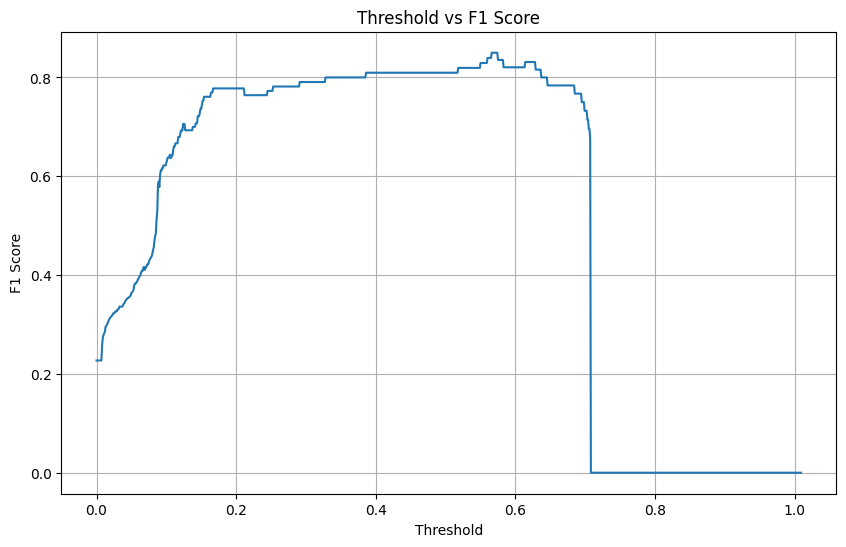

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Initialize lists to store results
thresholds = np.arange(0, 1.01, 0.001)
f1_scores = []

# Calculate F1 score for each threshold
for threshold in thresholds:
    pred_labels = []
    for i in range(len(probs)):
        temp = []
        for j in range(len(probs[i])):
            if probs[i][j] > threshold: 
                temp.append(1)
            else: 
                temp.append(0)
        pred_labels.append(temp)

    preds = []
    for i in pred_labels:
        if sum(i) > 5: 
            preds.append(1)
        else: 
            preds.append(0)
    
    f1 = f1_score(label, preds)
    f1_scores.append(f1)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'threshold': thresholds,
    'f1_score': f1_scores
})

# Print the DataFrame
print(results_df)

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['f1_score'])
plt.title('Threshold vs F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

/vast/palmer/scratch/liu_xiaofeng/ss4786/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vast/palmer/scratch/liu_xiaofeng/ss4786/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vast/palmer/scratch/liu_xiaofeng/ss4786/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

      threshold  f1_score  precision  recall      erde5     erde50
0         0.000  0.227147   0.128125     1.0  11.256651  11.170898
1         0.001  0.227147   0.128125     1.0  11.256651  11.170898
2         0.002  0.227147   0.128125     1.0  11.256651  11.170898
3         0.003  0.227147   0.128125     1.0  11.256651  11.170898
4         0.004  0.227147   0.128125     1.0  11.256651  11.170898
...         ...       ...        ...     ...        ...        ...
1005      1.005  0.000000   0.000000     0.0  12.812500  12.812500
1006      1.006  0.000000   0.000000     0.0  12.812500  12.812500
1007      1.007  0.000000   0.000000     0.0  12.812500  12.812500
1008      1.008  0.000000   0.000000     0.0  12.812500  12.812500
1009      1.009  0.000000   0.000000     0.0  12.812500  12.812500

[1010 rows x 6 columns]


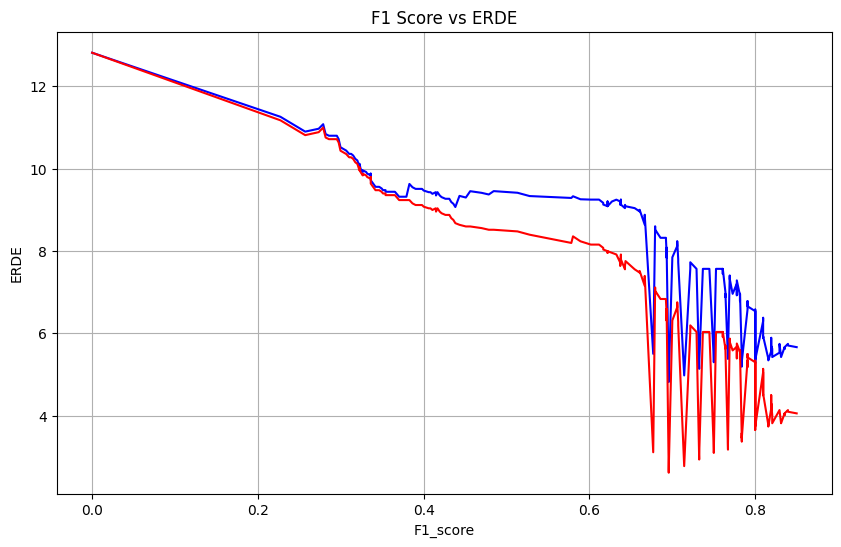

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

# Initialize lists to store results
thresholds = np.arange(0, 1.01, 0.001)
f1_scores, precision, recall, ERDE5, ERDE50 = [], [], [], [], []
cfp = 0.01  # Cost of false positive
cfn = 1     # Cost of false negative
ctp = 1     # Cost of true positive
o = 5       # Parameter controlling the rate of increase for latency cost

# Calculate F1 score for each threshold
for threshold in thresholds:
    pred_labels = []
    for i in range(len(probs)):
        temp = []
        for j in range(len(probs[i])):
            if probs[i][j] > threshold: 
                temp.append(1)
            else: 
                temp.append(0)
        pred_labels.append(temp)

    delays = get_delays(pred_labels, delay)

    preds = []
    for i in pred_labels:
        if sum(i) > 5: 
            preds.append(1)
        else: 
            preds.append(0)
    
    f1_scores.append(f1_score(label, preds))
    precision.append(precision_score(label, preds))
    recall.append(recall_score(label, preds))

    preds = []
    for i in pred_labels:
        if sum(i) > 0: 
            preds.append(1)
        else: 
            preds.append(0)

    ERDE5.append(100*calculate_ERDE(preds, delays, label, cfn, ctp, o))
    ERDE50.append(100*calculate_ERDE(preds, delays, label, cfn, ctp, o*10))



# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'threshold': thresholds,
    'f1_score': f1_scores,
    'precision': precision,
    'recall': recall,
    'erde5': ERDE5,
    'erde50': ERDE50
})

# Print the DataFrame
print(results_df)

# Plot the curve
f1_scores = np.array(f1_scores)
ERDE5 = np.array(ERDE5)
ERDE50 = np.array(ERDE50)
sorted_indices = np.argsort(f1_scores)
sorted_erde5 = ERDE5[sorted_indices]
sorted_erde50 = ERDE50[sorted_indices]
sorted_f1 = f1_scores[sorted_indices]

plt.figure(figsize=(10, 6))

plt.plot(sorted_f1, sorted_erde5, color='blue')
plt.plot(sorted_f1, sorted_erde50, color='red')
plt.title('F1 Score vs ERDE')
plt.xlabel('F1_score')
plt.ylabel('ERDE')
plt.grid(True)
plt.show()


In [24]:
results_df.to_csv('/vast/palmer/scratch/liu_xiaofeng/ss4786/sourav/longformer_patchtst_7_6.csv')